# Listing 6-1. Python Implementation of Binary thresholding Method based on Histogram of Pixel Intensities and Otsu's Method

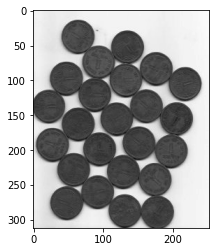

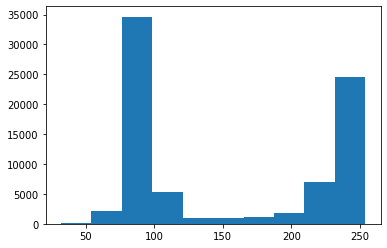

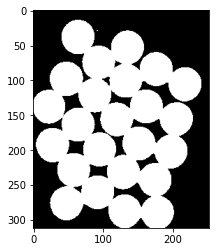

In [2]:
"""
 Binary thresholding Method

    From the histogram plotted below it's evident that the distribution is bimodal with the lowest probability around
    at around pixel value of 150. Hence 150 would be a good threshold for binary segmentation
"""

import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
img = cv2.imread("/home/santanu/Downloads/coins.jpg")
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.figure(1)
plt.imshow(gray,cmap='gray')
row,col = np.shape(gray)
gray_flat = np.reshape(gray,(row*col,1))[:,0]
plt.figure(2)
plt.hist(list(gray_flat))
gray_const = []
for i in range(len(gray_flat)):
    if gray_flat[i] < 150 :
        gray_const.append(255)
    else:
        gray_const.append(0)
gray_const = np.reshape(np.array(gray_const),(row,col))    
plt.figure(3)
plt.imshow(gray_const,cmap='gray')

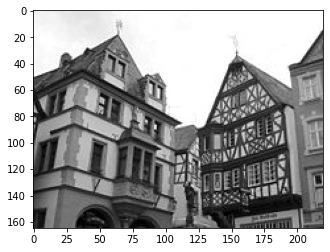

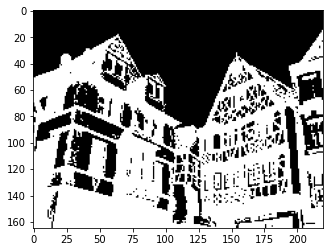

In [8]:
"""
  Otsu's thresholding Method  - Determines the threshold by maximizing the interclass variance 
"""

img = cv2.imread("/home/santanu/Downloads/otsu.jpg")
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.figure(1)
plt.imshow(gray,cmap='gray')
row,col = np.shape(gray)
hist_dist = 256*[0]
# Compute the frequency count of each of the pixel in the image
for i in range(row):
    for j in range(col):
        hist_dist[gray[i,j]] += 1
# Normalize the frequencies to produce probabilities
hist_dist = [c/float(row*col) for c in hist_dist]
# Compute the between segment variance 
def var_c1_c2_func(hist_dist,t):
    u1,u2,p1,p2,u = 0,0,0,0,0
    for i in range(t+1):
        u1 += hist_dist[i]*i
        p1 += hist_dist[i]
    for i in range(t+1,256): 
        u2 += hist_dist[i]*i
        p2 += hist_dist[i]
    for i in range(256):
        u += hist_dist[i]*i
    var_c1_c2 = p1*(u1 - u)**2 + p2*(u2 - u)**2
    return var_c1_c2
# Iteratively run through all the pixel intensities from 0 to 255 and chose the one that 
# maximizes the variance 

variance_list = []
for i in range(256):
    var_c1_c2 = var_c1_c2_func(hist_dist,i)
    variance_list.append(var_c1_c2)
## Fetch the threshold that maximizes the variance
t_hat = np.argmax(variance_list)
## Compute the segmented image based on the threshold t_hat

gray_recons = np.zeros((row,col))

for i in range(row):
    for j in range(col):
        if gray[i,j] <= t_hat :
            gray_recons[i,j] = 255
        else:
            gray_recons[i,j] = 0
plt.figure(2)
plt.imshow(gray_recons,cmap='gray') 

# Listing 6-2. Image Segmentation using Watershed Algorithm

[INFO] 24 unique segments found


/tmp/ipykernel_28965/1469897724.py:43: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  localMax = peak_local_max(D, indices=False, min_distance=10,


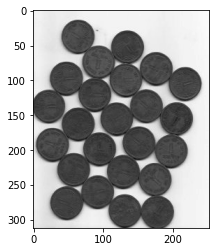

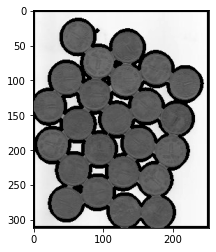

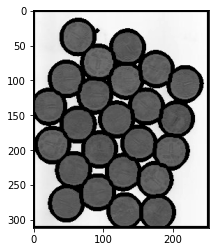

In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
# Load the coins image
img = cv2.imread("/home/santanu/Downloads/coins.jpg")
# Convert the image to gray scale
imgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.figure(1)
plt.imshow(imgray,cmap='gray')
# Threshold the image to convert it to Binary image based on Otsu's method
thresh = cv2.threshold(imgray, 0, 255,
cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

"""
 Detect the contours and display them
 As we can see in the 2nd image below that the contours are not prominent at the regions of
 overlap with normal thresholding method. However with Wateshed algorithm the 
 the same is possible because of its ability to better separate regions of overlap by
 building watersheds at the boundaries of different basins of pixel intensity minima
"""
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
y = cv2.drawContours(imgray, contours, -1, (0,255,0), 3)
plt.figure(2)
plt.imshow(y,cmap='gray')
"""
 Hence we will proceed with the Watershed algorithm so that each of the coin form its own
 cluster and hence its possible to have separate contours for each coin.
 Relabel the thresholded image to be consisting of only 0 and 1
 as the input image to distance_transform_edt should be in this format.
"""
thresh[thresh == 255] = 5
thresh[thresh == 0] = 1
thresh[thresh == 5] = 0
"""
 The distance_transform_edt and the peak_local_max functions helps building the markers by detecting
 points near the centre points of the coins. One can skip these steps and create a marker
 manually by setting one pixel within each coin with a random number represneting its cluster
"""
D = ndimage.distance_transform_edt(thresh)
localMax = peak_local_max(D, indices=False, min_distance=10,
labels=thresh)
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
"""
 Provide the EDT distance matrix and the markers to the watershed algorithm to detect the clusters
 labels for each pixel. For each coin, the pixels corresponding to it will be filled with the cluster number
"""
labels = watershed(-D, markers, mask=thresh)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))
#Create the contours for each label(each coin and append to the plot)
for k in np.unique(labels):
    if k != 0 :
        labels_new = labels.copy()
        labels_new[labels == k] = 255
        labels_new[labels != k] = 0
        labels_new = np.array(labels_new,dtype='uint8')
        contours, hierarchy = cv2.findContours(labels_new,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        z = cv2.drawContours(imgray,contours, -1, (0,255,0), 3)
        plt.figure(3)
        plt.imshow(z,cmap='gray') 

# Listing 6-3.Image Segmentation using K-means

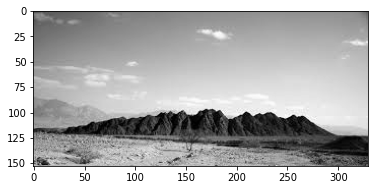

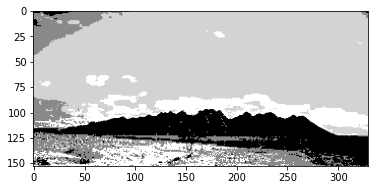

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)
"""
  K means that one has used in Machine learning 
 clustering also provides good segmentation as we see below
"""

img = cv2.imread("/home/santanu/Downloads/kmeans1.jfif")
imgray_ori = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.figure(1)
plt.imshow(imgray_ori,cmap='gray')
# Save the dimensions of the image
row,col,depth = img.shape
# Collapse the row and column axis for faster matrix operation.
img_new = np.zeros(shape=(row*col,3))
glob_ind = 0 
for i in range(row):
    for j in range(col):
        u = np.array([img[i,j,0],img[i,j,1],img[i,j,2]]) 
        img_new[glob_ind,:] = u
        glob_ind += 1

"""
 Set the number of clusters
 One can experiment with different values of K and select 
 the one that provides good clustering. Having said that Image processing
 especially image enhancement and segmentation to some extent is subjective.
"""
K = 5
num_iter = 20
"""
 K means suffers from local minima solution and hence 
 its better to trigger K-means several times with different random seed value
"""
for g in range(num_iter):
    # Define cluster for storing the cluster number and out_dist to store the distances from centroid
    clusters = np.zeros((row*col,1))
    out_dist = np.zeros((row*col,K))
    centroids = np.random.randint(0,255,size=(K,3))

    for k in range(K):
        diff = img_new - centroids[k,:]
        diff_dist = np.linalg.norm(diff,axis=1)
        out_dist[:,k] = diff_dist

# Assign the cluster with minimum distance to a pixel location

    clusters = np.argmin(out_dist,axis=1)

# Recompute the clusters

    for k1 in np.unique(clusters):
        centroids[k1,:] = np.sum(img_new[clusters == k1,:],axis=0)/np.sum([clusters == k1])

# Reshape the cluster labels in two dimensional image form
clusters = np.reshape(clusters,(row,col))
out_image = np.zeros(img.shape)

#Form the 3-D image with the labels replaced by their correponding centroid pixel intensity

for i in range(row):
    for j in range(col):
        out_image[i,j,0] = centroids[clusters[i,j],0]
        out_image[i,j,1] = centroids[clusters[i,j],1]
        out_image[i,j,2] = centroids[clusters[i,j],2]
        out_image = np.array(out_image,dtype="uint8")

# Display the output image after converting into gray scale
# Readers adviced to display the image as it is for better clarity
imgray = cv2.cvtColor(out_image,cv2.COLOR_BGR2GRAY)
plt.figure(2)
plt.imshow(imgray,cmap='gray') 

In [20]:
from tensorflow.keras import layers, Model
layers.MaxPool2D

# Listing 6-4.Semantic Segmentation in TensorFlow with Fully Connected Neural Network

In [167]:
#-----------------------------------------------
# Load the different packages 
#-----------------------------------------------
import tensorflow as tf
print(f"Tensorflow version: {tf.__version__}")
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import os
from subprocess import check_output
import numpy as np
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
from  skimage.transform import resize
from tensorflow.keras import layers, Model
from pathlib import Path
import imageio

class segmentation_model(Model):
    def __init__(self):
        super(segmentation_model,self).__init__()
        self.conv11, self.conv12, self.pool1  = self.conv_block(filters=64,kernel_size=3,strides=1,
                                                                padding='SAME',activation='relu',
                                                                pool_size=2,pool_stride=2)
        
        self.conv21, self.conv22, self.pool2  = self.conv_block(filters=128,kernel_size=3,strides=1,
                                                                padding='SAME',activation='relu',
                                                                pool_size=2,pool_stride=2)
        
        self.conv31, self.conv32, self.pool3  = self.conv_block(filters=256,kernel_size=3,strides=1,
                                                                padding='SAME',activation='relu',
                                                                pool_size=2,pool_stride=2)
        
        self.conv41, self.conv42, self.pool4  = self.conv_block(filters=512,kernel_size=3,strides=1,
                                                                padding='SAME',activation='relu',
                                                                pool_size=2,pool_stride=2)
        
        self.conv51, self.conv52              = self.conv_block(filters=1024,kernel_size=3,strides=1,
                                                                padding='SAME',activation='relu',
                                                                pool_size=2,pool_stride=2,pool=False)
        
        self.deconv1 = self.deconv_block(filters=1024,kernel_size=3,strides=2,padding='SAME',activation='relu')
        self.deconv2 = self.deconv_block(filters=512,kernel_size=3,strides=2,padding='SAME',activation='relu')
        self.deconv3 = self.deconv_block(filters=256,kernel_size=3,strides=2,padding='SAME',activation='relu')
        self.deconv4 = self.deconv_block(filters=128,kernel_size=3,strides=2,padding='SAME',activation='relu')
        #self.deconv5 = self.deconv_block(filters=64,kernel_size=3,strides=2,padding='SAME',activation='relu')
        
        self.convf = layers.Conv2D(filters=1,kernel_size=1,strides=1,padding='SAME')
        

        
    def conv_block(self,filters,kernel_size,strides,padding,activation,pool_size,pool_stride,pool=True):
        conv11 = layers.Conv2D(filters=filters,kernel_size=kernel_size,strides=(strides,strides),padding=padding,activation=activation)
        conv12 = layers.Conv2D(filters=filters,kernel_size=kernel_size,strides=(strides,strides),padding=padding,activation=activation)
        if pool:
            pool1  = layers.MaxPool2D(pool_size=(pool_size,pool_size),strides=(pool_stride,pool_stride))
            return conv11, conv12, pool1
        return conv11, conv12
                                         
        
    def deconv_block(self,filters,kernel_size,strides,padding,activation):
        deconv1 = layers.Conv2DTranspose(filters=filters,kernel_size=kernel_size,strides=(strides,strides),padding=padding,activation=activation)
        return deconv1
                                         
        
        
    
    def call(self,x):
        x = self.conv11(x)
        x = self.conv12(x)
        x = self.pool1(x)
        #print(x.shape)
        #
        x = self.conv21(x)
        x = self.conv22(x)
        x = self.pool2(x)
        #print(x.shape)
        #
        x = self.conv31(x)
        x = self.conv32(x)
        x = self.pool3(x)
        #print(x.shape)
        #
        x = self.conv41(x)
        x = self.conv42(x)
        x = self.pool4(x)
        #print(x.shape)
        #
        x = self.conv51(x)
        x = self.conv52(x)
        #x = self.pool5(x)
        print(x.shape)
        #
        x = self.deconv1(x)
        #print('d1',x.shape)
        x = self.deconv2(x)
        #print('d2',x.shape)
        x = self.deconv3(x)
        #print('d3',x.shape)
        x = self.deconv4(x)
        #print('d4',x.shape)
        #print(x.shape)
        #
        #x = self.deconv5(x)
        print(x.shape)
        x = self.convf(x)
        
        return x 
        
        
  

def grey2rgb(img):
    """
     utility function to convert greyscale images to rgb
    """
    new_img = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img.append(list(img[i][j])*3)
    new_img = np.array(new_img).reshape(img.shape[0], img.shape[1], 3)
    return new_img


def data_gen_small(data_dir, mask_dir, images, batch_size, dims):
    """
    Generator that we will use to read the data from the directory
    """
    while True:
        ix = np.random.choice(np.arange(len(images)), batch_size)
        imgs = []
        labels = []
        for i in ix:
            # images
            img_path = f"{Path(data_dir)}/{images[i]}"
            original_img = imageio.imread(img_path)
            
            resized_img = resize(original_img, dims)
            array_img = img_to_array(resized_img)
            imgs.append(array_img)
                
            # masks
            prefix = images[i].split(".")[0]
            mask_path = f"{Path(mask_dir)}/{prefix}_mask.gif"
            original_mask = imageio.imread(mask_path)
            resized_mask = resize(original_mask, dims)
            array_mask = img_to_array(resized_mask)
            labels.append(array_mask[:, :, 0])
        imgs = np.array(imgs)
        labels = np.array(labels)
        yield imgs, labels.reshape(-1, dims[0], dims[1],1)
            
def train(data_dir,mask_dir,batch_size=4,train_val_split=[0.8,0.2],img_height=128,img_width=128,lr=0.01,num_batches=500):
    
    model = segmentation_model()
    model_graph = tf.function(model)
    
    # Get the path to all images for dynamic fetch in each batch generation
    all_images = os.listdir(data_dir)
    # Train val split  
    train_images, validation_images = train_test_split(all_images, train_size=train_val_split[0], test_size=train_val_split[1])
    # Create train and val generator
    train_gen = data_gen_small(data_dir, mask_dir, train_images,batch_size=batch_size,dims=(img_height,img_width))
    validation_gen = data_gen_small(data_dir, mask_dir, validation_images,batch_size=batch_size, dims=(img_height,img_width))
    
    optimizer = tf.keras.optimizers.Adam(lr)
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    


    for batch in range(num_batches):
        
        X_batch,y_batch = next(train_gen)
        X_batch, y_batch =  tf.constant(X_batch), tf.constant(y_batch)
        
        with tf.GradientTape() as tape:
            y_pred_batch = model_graph(X_batch)
            loss_ = loss_fn(y_batch,y_pred_batch)
        
        # Compute gradient
        gradients = tape.gradient(loss_, model.trainable_variables)
        # Update the parameters
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        X_val,y_val = next(validation_gen)
        X_val,y_val = tf.constant(X_val), tf.constant(y_val)
        y_val_pred = model_graph(X_val,training=False)
        loss_val = loss_fn(y_val,y_val_pred)
        print(f"Batch : {batch} , train loss:{loss_.numpy()/batch_size}, val loss: {loss_val/batch_size}")
    return model, model_graph, X_val,y_val, y_val_pred



Tensorflow version: 2.9.1


In [ ]:
height,width=128,128
data_dir = "/media/santanu/9eb9b6dc-b380-486e-b4fd-c424a325b976/Kaggle Competitions/Carvana/train/"
mask_dir = "/media/santanu/9eb9b6dc-b380-486e-b4fd-c424a325b976/Kaggle Competitions/Carvana/train_masks/"
model, model_graph, X_val,y_val, y_val_pred = train(data_dir,mask_dir,batch_size=4,train_val_split=[0.8,0.2],img_height=height,img_width=width,lr=0.0002,num_batches=500)

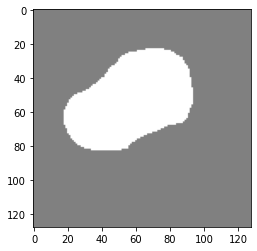

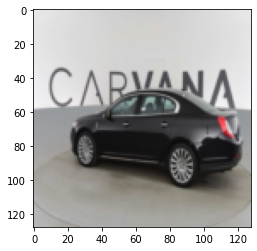

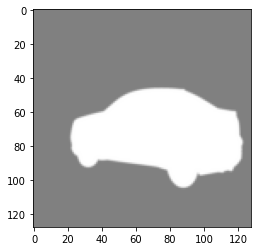

In [178]:
"""
    Validating results 
     1st image - Output segmented image
     2nd image - Original image
     3rd image - Ground truth
"""
img = (y_val_pred.numpy()[2] > 0.5)*1.0
plt.figure(1)
plt.imshow(grey2rgb(img),alpha=0.5)
plt.figure(2)
plt.imshow(X_val.numpy()[1])
plt.figure(3)
plt.imshow(grey2rgb(y_val.numpy()[1]), alpha=0.5)


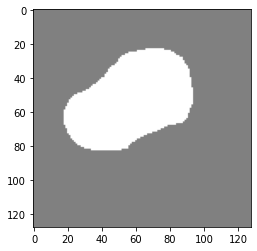

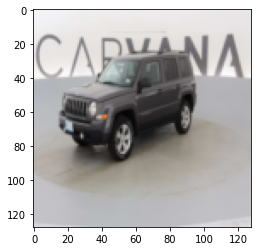

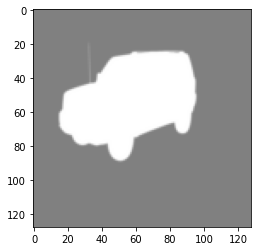

In [179]:
"""
    Validating results 
     1st image - Output segmented image
     2nd image - Original image
     3rd image - Ground truth
"""
img = (y_val_pred.numpy()[2] > 0.5)*1.0
plt.figure(4)
plt.imshow(grey2rgb(img),alpha=0.5)
plt.figure(5)
plt.imshow(X_val.numpy()[2])
plt.figure(6)
plt.imshow(grey2rgb(y_val.numpy()[2]), alpha=0.5) 

# Listing 6-5. Implementation of a Generative Adversarial Network

Epoch: 0 Iteration : 0, Discrinator loss: 1.1017875671386719, Generator loss: 0.7137295007705688
Epoch: 0 Iteration : 200, Discrinator loss: 0.2998032569885254, Generator loss: 1.2036678791046143
Epoch: 1 Iteration : 0, Discrinator loss: 0.2501879930496216, Generator loss: 1.4736047983169556
Epoch: 1 Iteration : 200, Discrinator loss: 0.1949506402015686, Generator loss: 1.8274062871932983
Epoch: 2 Iteration : 0, Discrinator loss: 0.2268180251121521, Generator loss: 2.093841314315796
Epoch: 2 Iteration : 200, Discrinator loss: 0.32480332255363464, Generator loss: 1.6181516647338867
Epoch: 3 Iteration : 0, Discrinator loss: 0.3639432489871979, Generator loss: 1.5107319355010986
Epoch: 3 Iteration : 200, Discrinator loss: 0.42706114053726196, Generator loss: 1.185171127319336
Epoch: 4 Iteration : 0, Discrinator loss: 0.28556936979293823, Generator loss: 1.5028413534164429
Epoch: 4 Iteration : 200, Discrinator loss: 0.3450779914855957, Generator loss: 1.3449459075927734
Epoch: 5 Iteration 

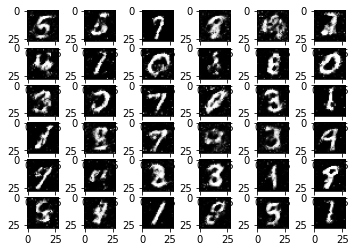

In [225]:
import tensorflow as tf
from tensorflow.keras import layers, Model, initializers,activations

## The dimension of the Prior Noise Signal is 100 
## The generator would have 150 and 300 hidden units successively before 784 outputs corresponding
## to 28x28 image size

h1_dim = 150
h2_dim = 300
dim = 100
batch_size = 256

class generator(Model):
    def __init__(self,hidden_units=[500,500]):
        super(generator,self).__init__()
        self.fc1 = layers.Dense(hidden_units[0],activation='relu',kernel_initializer=initializers.TruncatedNormal(mean=0.0, stddev=0.1))
        self.fc2 = layers.Dense(hidden_units[1],activation='relu',kernel_initializer=initializers.TruncatedNormal(mean=0.0, stddev=0.1))
        self.fc3 = layers.Dense(28*28,activation=activations.tanh,kernel_initializer=initializers.TruncatedNormal(mean=0.0, stddev=0.1))
    
    def call(self,x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
    
class discriminator(Model):
    def __init__(self,hidden_units=[500,500],dropout_rate=0.3):
        super(discriminator,self).__init__()
        self.fc1 = layers.Dense(hidden_units[0],activation='relu',kernel_initializer=initializers.TruncatedNormal(mean=0.0, stddev=0.1))
        self.drop1 = layers.Dropout(rate=dropout_rate)
        self.fc2 = layers.Dense(hidden_units[1],activation='relu',kernel_initializer=initializers.TruncatedNormal(mean=0.0, stddev=0.1))
        self.drop2 = layers.Dropout(rate=dropout_rate)
        self.fc3 = layers.Dense(1,kernel_initializer=initializers.TruncatedNormal(mean=0.0, stddev=0.1))
        
    
    def call(self,x):
        x = self.fc1(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        x = self.fc3(x)
        
        return x

class GAN(Model):
    def __init__(self,G,D):
        super(GAN,self).__init__()
        self.G = G
        self.D = D
        
    def call(self,z):
        z = self.G(z)
        z = self.D(z)
        return z


        
    
        
        

        
def data_load():
    (train_X, train_Y), (test_X, test_Y) = tf.keras.datasets.mnist.load_data()
    train_X, test_X , = train_X.reshape(-1,28*28), test_X.reshape(-1,28*28)
    train_X, test_X = train_X/255.0, test_X/255.0
    train_X, test_X = 2*train_X - 1, 2*test_X - 1
    return np.float32(train_X), train_Y, np.float32(test_X), test_Y
    
def train(lr=0.0001,batch_size=256,hidden_units=[150,130],dim=100,dropout_rate=0.3,num_epochs=300):
    
    G_ = generator(hidden_units=hidden_units)
    D_ = discriminator(hidden_units=hidden_units[::-1],dropout_rate=dropout_rate)
    model = GAN(G_,D_)
    G_graph, D_graph, model_graph = tf.function(G_), tf.function(D_), tf.function(model)    
    
    optimizer = tf.keras.optimizers.Adam(lr)
    
    train_X, train_Y, test_X, test_Y = data_load()
    num_train = train_X.shape[0]
    order = np.arange(num_train)
    num_batches = num_train//batch_size
    
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.NONE)
    
    for epoch in range(num_epochs):
        np.random.shuffle(order)
        train_X, train_Y = train_X[order], train_Y[order]
        
        for i in range(num_batches):
            x_ = train_X[batch_size*i:(i+1)*batch_size]
            z_ = np.random.uniform(-1, 1, size=(x_.shape[0],dim)).astype(np.float32)
            y_label_real_dis = np.array([1. for i in range(x_.shape[0])]).reshape(-1,1)
            y_label_fake_dis = np.array([0. for i in range(x_.shape[0])]).reshape(-1,1)
            y_label_gen = np.array([1. for i in range(x_.shape[0])]).reshape(-1,1)
            
            x_,z_, y_label_real_dis, y_label_fake_dis,y_label_gen = tf.constant(x_), tf.constant(z_), tf.constant(y_label_real_dis) , tf.constant(y_label_fake_dis), tf.constant(y_label_gen)
            

            with tf.GradientTape(persistent=True) as tape:
                y_pred_fake = model_graph(z_,training=True)
                y_pred_real = D_graph(x_,training=True)
                
                #print(loss_fn(y_label_fake_dis,y_pred_fake))
               
                loss_discrimator = 0.5*tf.reduce_mean(loss_fn(y_label_fake_dis,y_pred_fake) +  loss_fn(y_label_real_dis,y_pred_real))
                loss_generator = tf.reduce_mean(loss_fn(y_label_gen,y_pred_fake))
            # Compute gradient
            grad_d = tape.gradient(loss_discrimator, D_.trainable_variables)
            grad_g = tape.gradient(loss_generator, G_.trainable_variables)
            # update the parameters
            optimizer.apply_gradients(zip(grad_d, D_.trainable_variables))
            optimizer.apply_gradients(zip(grad_g, G_.trainable_variables))
            del tape
            if (i % 200) == 0:   
                print (f"Epoch: {epoch} Iteration : {i}, Discrinator loss: {loss_discrimator.numpy()}, Generator loss: {loss_generator.numpy()}")
    
    # Generator some images 
    z_ = tf.constant(np.random.uniform(-1, 1, size=(batch_size,dim)).astype(np.float32))
    imgs = 0.5*(G_graph(z_,training=False) + 1).numpy()
    print(imgs.shape)
    for k in range(36):
        plt.subplot(6,6,k+1)
        image = np.reshape(imgs[k],(28,28))
        plt.imshow(image,cmap='gray')
        
    return G_, D_, model, G_graph, D_graph, model_graph, imgs    
    

G_, D_, model, G_graph, D_graph, model_graph,imgs_val   = train()
    

# Listing 6-6. Implementation of a CycleGAN


In [50]:
from __future__ import print_function, division
# import scipy
import tensorflow as tf
from tensorflow.keras import layers, Model
import datetime
import matplotlib.pyplot as plt
# import sys
# from data_loader import DataLoader
import numpy as np
import os
import time
import glob
import copy
from imageio import imread, imsave
#from skimage.transform import resize 
from cv2 import resize
from pathlib import Path



def load_train_data(image_path, dim=64, is_testing=False):
    img_A = imread(image_path[0])
    img_B = imread(image_path[1])
    # Resize
    #print('1',img_A.max(),img_A.min()) 
    img_A = resize(img_A, [dim, dim])
    img_B = resize(img_B, [dim, dim])
    if not is_testing:
        
        if np.random.random() >= 0.5:
            img_A = np.fliplr(img_A)
            img_B = np.fliplr(img_B)

    #print('2',img_A.max(),img_A.min())     
    img_A = 2*(img_A/255.0) - 1
    img_B = 2*(img_B/255.0) - 1

    img_AB = np.concatenate((img_A, img_B), axis=2)

    return img_AB


def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1], 3))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j * h:j * h + h, i * w:i * w + w, :] = image

    return img


def image_save(images, size, path):
    return imsave(path, merge(images, size))


def save_images(images, size, image_path):
    return image_save(inverse_transform(images), size, image_path)


def inverse_transform(images):
    return (images + 1) * 127.5


class ImagePool(object):
    def __init__(self, maxsize=50):
        self.maxsize = maxsize
        self.num_img = 0
        self.images = []

    def __call__(self, image):
        if self.maxsize <= 0:
            return image
        if self.num_img < self.maxsize:
            self.images.append(image)
            self.num_img += 1
            return image
        if np.random.rand() > 0.5:
            idx = int(np.random.rand() * self.maxsize)
            tmp1 = copy.copy(self.images[idx])[0]
            self.images[idx][0] = image[0]
            idx = int(np.random.rand() * self.maxsize)
            tmp2 = copy.copy(self.images[idx])[1]
            self.images[idx][1] = image[1]
            return [tmp1, tmp2]
        else:
            return image


class customConv2D(layers.Layer):
    def __init__(self, filters, kernel_size=4, strides=2, padding='SAME', norm=True, alpha=0.2, activation='lrelu'):
        super(customConv2D, self).__init__()
        self.norm = norm
        self.conv1 = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=(strides, strides),
                                   padding=padding)
        if self.norm:
            self.bnorm = layers.BatchNormalization()
        if activation == 'lrelu':
            self.activation = layers.LeakyReLU(alpha=alpha)
        elif activation == 'relu':
            self.activation = layers.ReLU()

    def call(self, x):
        x = self.conv1(x)
        if self.norm:
            x = self.bnorm(x)
        x = self.activation(x)
        return x


class customDeConv2D(layers.Layer):
    def __init__(self, filters, kernel_size=4, strides=2, padding='SAME', dropout_rate=0):
        super(customDeConv2D, self).__init__()
        self.dropout_rate = dropout_rate
        self.deconv1 = layers.Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=(strides, strides),
                                              padding=padding)
        if self.dropout_rate > 0:
            self.drop = layers.Dropout(rate=dropout_rate)

        self.bnorm = layers.BatchNormalization()
        self.activation = layers.ReLU()

    def call(self, x):
        x = self.deconv1(x)
        if self.dropout_rate > 0:
            x = self.drop(x)
        x = self.bnorm(x)
        x = self.activation(x)
        return x


class generator(Model):
    def __init__(self, gf, channels=3):
        super(generator, self).__init__()
        self.down1 = customConv2D(filters=gf, strides=2, norm=False)
        self.down2 = customConv2D(filters=gf * 2, strides=2)
        self.down3 = customConv2D(filters=gf * 4, strides=2)
        self.down4 = customConv2D(filters=gf * 8, strides=2)
        self.down5 = customConv2D(filters=100, strides=1, padding='VALID')

        self.up1 = customDeConv2D(filters=gf * 8, strides=1, padding='VALID')
        self.up2 = customDeConv2D(filters=gf * 4, strides=2)
        self.up3 = customDeConv2D(filters=gf * 2, strides=2)
        self.up4 = customDeConv2D(filters=gf, strides=2)
        self.convf = layers.Conv2DTranspose(filters=channels, kernel_size=4, strides=(2, 2), padding='SAME',
                                   activation=tf.nn.tanh)

    def call(self, x):
        x = self.down1(x)
        #print(x.shape)
        x = self.down2(x)
        #print(x.shape)
        x = self.down3(x)
        #print(x.shape)
        x = self.down4(x)
        #print(x.shape)
        x = self.down5(x)
        #print('down 5',x.shape)

        x = self.up1(x)
        #print('up1',x.shape)
        x = self.up2(x)
        #print('up2',x.shape)
        x = self.up3(x)
        #print('up3',x.shape)
        x = self.up4(x)
        #print('up4',x.shape)
        x = self.convf(x)
        #print('upf',x.shape)
        return x


class discriminator(Model):

    def __init__(self, df):
        super(discriminator, self).__init__()
        self.down1 = customConv2D(filters=df, strides=2, norm=False)
        self.down2 = customConv2D(filters=df * 2, strides=2)
        self.down3 = customConv2D(filters=df * 4, strides=2)
        self.down4 = customConv2D(filters=df * 8, strides=2)
        self.down5 = layers.Conv2D(filters=1, kernel_size=4, strides=1, padding='VALID')

    def call(self, x):
        x = self.down1(x)
        x = self.down2(x)
        x = self.down3(x)
        x = self.down4(x)
        x = self.down5(x)

        return x


class GAN_X2Y(Model):
    def __init__(self, G_XY, D_Y):
        super(GAN_X2Y, self).__init__()
        self.G_XY = G_XY
        self.D_Y = D_Y

    def call(self, x):
        fake_x = self.G_XY(x)
        x = self.D_Y(x)
        return fake_x,x



def process_data(data_dir,skip_preprocess=False):
    """
    Split the images into domain A and domain B images
    Each image contain both Domain A and Domain B images together
    This routines splits it up
    :param data_dir: Input images dir 
    :return: 
    """
    assert Path(data_dir).exists()
    
    domain_A_dir = f'{Path(data_dir)}/trainA'
    domain_B_dir = f'{Path(data_dir)}/trainB'
    if skip_preprocess:
        return domain_A_dir, domain_B_dir
    os.makedirs(domain_A_dir,exist_ok=True)
    os.makedirs(domain_B_dir,exist_ok=True)
    files = os.listdir(Path(data_dir))
    print(f'Images to process: {len(files)}')
    
    i = 0
    for fl in files:
        i += 1
        try:
            img = imread(f"{Path(data_dir)}/{str(fl)}")
            #print(img.shape)
            w, h, d = img.shape
            img_A = img[:w, :int(h / 2), :d]
            img_B = img[:w, int(h / 2):h, :d]
            imsave(f"{data_dir}/trainA/{fl}_A.jpg", img_A)
            imsave(f"{data_dir}/trainB/{fl}_B.jpg", img_B)
            if (i % 10000) == 0 & (i >= 10000):
                print(f"processed {i+1} images")
        except:
            print(f"Skip processing image {Path(data_dir)}/{str(fl)}")

    return domain_A_dir, domain_B_dir




def train(data_dir,sample_dir,num_epochs=5,lr=0.0002,beta1=0.5,beta2=0.99,train_size=10000,batch_size=64,epoch_intermediate=10,dim=64,sample_freq=5,_lambda_=0.5,skip_preprocess=False):
    
    # Process input data and split to domain A, domain B data
    domain_A_dir, domain_B_dir = process_data(data_dir=data_dir,skip_preprocess=skip_preprocess)
    
    # Build the models
    G_AB, G_BA = generator(gf=64), generator(gf=64)
    D_A, D_B = discriminator(df=64), discriminator(df=64)
    GAN_AB = GAN_X2Y(G_XY=G_AB,D_Y=D_B)
    GAN_BA = GAN_X2Y(G_XY=G_BA,D_Y=D_A)
    G_AB_g, G_BA_g, D_A_g, D_B_g, GAN_AB_g,  GAN_BA_g =  tf.function(G_AB), tf.function(G_BA), \
                tf.function(D_A), tf.function(D_B), tf.function(GAN_AB),  tf.function(GAN_BA)
    
    # Setup the imagepool
    pool = ImagePool()
    
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.NONE)
    for epoch in range(num_epochs):
        data_A = os.listdir(domain_A_dir)
        data_B = os.listdir(domain_B_dir)
        data_A = [f"{domain_A_dir}/{str(x)}" for x in data_A]
        data_B = [f"{domain_B_dir}/{str(x)}" for x in data_B]
        np.random.shuffle(data_A)
        np.random.shuffle(data_B)
        
        if not train_size:
            train_size = min(len(data_A), len(data_B))
        num_batches = min(len(data_A), len(data_B),train_size)
        
        # Setup lr based on the schedule
        lr_curr =  lr if epoch < epoch_intermediate else lr* (num_epochs - epoch) / (num_epochs - epoch_intermediate)
        # Set the optimizer
        optimizer = tf.keras.optimizers.Adam(lr_curr,beta_1=beta1,beta_2=beta2)
                
        for i in range(num_batches):
            batch_files = list(zip(data_A[i*batch_size:(i + 1)* batch_size],
                                       data_B[i*batch_size:(i + 1)* batch_size]))
            batch_images = [load_train_data(batch_file, dim) for batch_file in batch_files]
            batch_images = np.array(batch_images).astype(np.float32)
            image_real_A = tf.constant(batch_images[:,:,:,:3])
            image_real_B = tf.constant(batch_images[:,:,:,3:6])
            #print(image_real_A.shape,image_real_B.shape)
            
            
            with tf.GradientTape(persistent=True) as tape:
                
                fake_AB, logit_fake_AB = GAN_AB_g(image_real_A)
                fake_BA, logit_fake_BA = GAN_BA_g(image_real_B)
                #print(fake_AB.shape,fake_BA.shape)
                A_reconst = G_BA_g(fake_AB)
                B_reconst = G_AB_g(fake_BA)
                logit_real_D_B = D_B_g(image_real_B)
                logit_real_D_A = D_A_g(image_real_A)
                print(logit_fake_AB.shape)
                D_B_loss_fake = tf.reduce_mean(loss_fn(tf.zeros_like(logit_fake_AB),logit_fake_AB))   
                D_B_loss_real = tf.reduce_mean(loss_fn(tf.ones_like(logit_real_D_B),logit_real_D_B))
                D_B_loss   = 0.5*(D_B_loss_fake + D_B_loss_real)
                
                D_A_loss_fake   = tf.reduce_mean(loss_fn(tf.zeros_like(logit_fake_BA),logit_fake_BA))   
                D_A_loss_real   = tf.reduce_mean(loss_fn(tf.ones_like(logit_real_D_A),logit_real_D_A))
                D_A_loss   = 0.5*(D_A_loss_fake + D_A_loss_real)
                loss_discriminator = D_B_loss + D_A_loss
                
                loss_G_ABA = _lambda_*tf.reduce_mean(tf.abs(A_reconst - image_real_A))
                loss_G_A_DB  = tf.reduce_mean(loss_fn(tf.ones_like(logit_fake_AB),logit_fake_AB))
                loss_G_AB     =  loss_G_ABA + loss_G_A_DB
                
                loss_G_BAB = _lambda_*tf.reduce_mean(tf.abs(B_reconst - image_real_B))
                loss_G_B_DA  = tf.reduce_mean(loss_fn(tf.ones_like(logit_fake_BA),logit_fake_BA))
                loss_G_BA     =  loss_G_BAB + loss_G_B_DA
                
                loss_generator = loss_G_AB + loss_G_BA
            # Compute gradient
            print(f"Epoch, iter {epoch,i}:  D_B_loss:{D_B_loss_fake.numpy(),D_B_loss_real.numpy()},D_A_loss:{D_A_loss_fake.numpy(),D_A_loss_real.numpy()}, \
                  loss_G_AB:{loss_G_ABA.numpy(),loss_G_A_DB.numpy()},loss_G_BA:{loss_G_BAB.numpy(),loss_G_B_DA.numpy()}")
            grad_D_A = tape.gradient(D_A_loss, D_A.trainable_variables)
            grad_D_B = tape.gradient(D_B_loss, D_B.trainable_variables)
            grad_G_AB = tape.gradient(loss_G_AB,G_AB.trainable_variables)
            grad_G_BA = tape.gradient(loss_G_BA,G_BA.trainable_variables)
            # update the parameters
            optimizer.apply_gradients(zip(grad_D_A, D_A.trainable_variables))
            optimizer.apply_gradients(zip(grad_D_B, D_B.trainable_variables))
            optimizer.apply_gradients(zip(grad_G_AB, G_AB.trainable_variables))
            optimizer.apply_gradients(zip(grad_G_BA, G_BA.trainable_variables))
            del tape
            if i % sample_freq == 1:
                sample_model(sample_dir,data_dir, epoch, i,GAN_AB_g,GAN_BA_g)
    return G_AB, G_BA, D_A, D_B, GAN_AB,  GAN_BA 
            

            
def sample_model(sample_dir,data_dir,epoch, batch_num,GAN_AB_g,GAN_BA_g,batch_size=64,dim=64):
    assert sample_dir != None
    if not Path(sample_dir).exists():
        os.makedirs(f"{Path(sample_dir)}")
    data_A = os.listdir(f"{data_dir}/trainA")
    data_B = os.listdir(f"{data_dir}/trainB") 
    data_A = [f"{Path(data_dir)}/trainA/{str(file_name)}" for file_name in data_A ]
    data_B = [f"{Path(data_dir)}/trainB/{str(file_name)}" for file_name in data_B ]
 

    np.random.shuffle(data_A)
    np.random.shuffle(data_B)
    batch_files = list(zip(data_A[:batch_size], data_B[:batch_size]))
    sample_images = [load_train_data(batch_file, is_testing=True,dim=dim) for batch_file in batch_files]
    sample_images = np.array(sample_images).astype(np.float32)
    image_real_A = tf.constant(sample_images[:,:,:,:3])
    image_real_B = tf.constant(sample_images[:,:,:,3:6])
        
    fake_AB, logit_fake_AB = GAN_AB_g(image_real_A,training=False)
    fake_BA, logit_fake_BA = GAN_BA_g(image_real_B,training=False)

        
    save_images(fake_AB, [batch_size, 1],
                    '{}/A_{:02d}_{:04d}.jpg'.format(sample_dir, epoch, batch_num))
    save_images(fake_BA, [batch_size, 1],
                    '{}/B_{:02d}_{:04d}.jpg'.format(sample_dir, epoch, batch_num))
        


In [ ]:
data_dir='/media/santanu/9eb9b6dc-b380-486e-b4fd-c424a325b976/edges2handbags/train'
sample_dir='/home/santanu/generated_samples'
G_AB_g, G_BA_g, D_A_g, D_B_g, GAN_AB_g,  GAN_BA_g  = train(data_dir=data_dir,sample_dir=sample_dir,skip_preprocess=True)         

(64, 1, 1, 1)
Epoch, iter (0, 0):  D_B_loss:(0.69508344, 0.686507),D_A_loss:(0.6730642, 0.7194115),                   loss_G_AB:(0.46526447, 0.6912416),loss_G_BA:(0.3900148, 0.7137891)
(64, 1, 1, 1)
Epoch, iter (0, 1):  D_B_loss:(0.49095875, 0.7051947),D_A_loss:(0.7827076, 0.4048879),                   loss_G_AB:(0.45925343, 0.9471139),loss_G_BA:(0.3837862, 0.618662)


Lossy conversion from float64 to uint8. Range [127.42203521728516, 127.57080078125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [127.40267181396484, 127.5905990600586]. Convert image to uint8 prior to saving to suppress this warning.


(64, 1, 1, 1)
Epoch, iter (0, 2):  D_B_loss:(0.27081397, 0.6719996),D_A_loss:(0.7032045, 0.24742278),                   loss_G_AB:(0.4633524, 1.4409294),loss_G_BA:(0.37738752, 0.72340584)
(64, 1, 1, 1)
Epoch, iter (0, 3):  D_B_loss:(0.18053752, 0.3243001),D_A_loss:(0.26687366, 0.3152774),                   loss_G_AB:(0.4643192, 1.8075671),loss_G_BA:(0.37916365, 1.6961589)
(64, 1, 1, 1)
Epoch, iter (0, 4):  D_B_loss:(0.03379266, 0.38061675),D_A_loss:(0.9265365, 0.00545401),                   loss_G_AB:(0.46698955, 3.4561038),loss_G_BA:(0.3872371, 1.3907706)
(64, 1, 1, 1)
Epoch, iter (0, 5):  D_B_loss:(3.5459814, 0.004144286),D_A_loss:(0.067838594, 0.37928712),                   loss_G_AB:(0.4652398, 0.030384548),loss_G_BA:(0.3740566, 4.648263)
(64, 1, 1, 1)
Epoch, iter (0, 6):  D_B_loss:(0.008729804, 0.6237426),D_A_loss:(0.4356902, 0.026089786),                   loss_G_AB:(0.46177065, 4.845218),loss_G_BA:(0.37831223, 3.3665636)


Lossy conversion from float64 to uint8. Range [127.42994689941406, 127.628173828125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [127.35110473632812, 127.63658142089844]. Convert image to uint8 prior to saving to suppress this warning.


(64, 1, 1, 1)
Epoch, iter (0, 7):  D_B_loss:(0.008502044, 0.45221853),D_A_loss:(0.20851347, 0.04516188),                   loss_G_AB:(0.46265912, 4.85422),loss_G_BA:(0.37699184, 5.6886578)
(64, 1, 1, 1)
Epoch, iter (0, 8):  D_B_loss:(0.027725698, 0.24376392),D_A_loss:(0.08753133, 0.101818755),                   loss_G_AB:(0.46405065, 3.639647),loss_G_BA:(0.363703, 6.523994)
(64, 1, 1, 1)
Epoch, iter (0, 9):  D_B_loss:(0.059499335, 0.24102141),D_A_loss:(0.17179969, 0.053086847),                   loss_G_AB:(0.46795055, 2.8830786),loss_G_BA:(0.38716006, 7.9105206)
(64, 1, 1, 1)
Epoch, iter (0, 10):  D_B_loss:(0.09899663, 0.19808811),D_A_loss:(0.112789065, 0.046570763),                   loss_G_AB:(0.46276233, 2.3921564),loss_G_BA:(0.39134112, 8.874407)
(64, 1, 1, 1)
Epoch, iter (0, 11):  D_B_loss:(0.10427531, 0.13639225),D_A_loss:(0.07371171, 0.05669458),                   loss_G_AB:(0.46176758, 2.3481197),loss_G_BA:(0.37256035, 10.692169)


Lossy conversion from float64 to uint8. Range [127.4099349975586, 127.81310272216797]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [127.22187805175781, 127.70793914794922]. Convert image to uint8 prior to saving to suppress this warning.


(64, 1, 1, 1)
Epoch, iter (0, 12):  D_B_loss:(0.05396077, 0.17099619),D_A_loss:(0.07773225, 0.018943598),                   loss_G_AB:(0.46641636, 2.9853036),loss_G_BA:(0.38258198, 9.796209)
(64, 1, 1, 1)
Epoch, iter (0, 13):  D_B_loss:(0.044760466, 0.12814097),D_A_loss:(0.012586977, 0.045858465),                   loss_G_AB:(0.4658762, 3.209349),loss_G_BA:(0.38856626, 13.122021)
(64, 1, 1, 1)
Epoch, iter (0, 14):  D_B_loss:(0.03660918, 0.15828699),D_A_loss:(0.15538499, 0.0036359916),                   loss_G_AB:(0.46655008, 3.3952396),loss_G_BA:(0.3795905, 14.149378)
(64, 1, 1, 1)
Epoch, iter (0, 15):  D_B_loss:(0.04858035, 0.09949057),D_A_loss:(0.022862548, 0.07816471),                   loss_G_AB:(0.46481887, 3.1708302),loss_G_BA:(0.38139138, 15.3572445)
(64, 1, 1, 1)
Epoch, iter (0, 16):  D_B_loss:(0.044765662, 0.1749599),D_A_loss:(0.22376476, 0.0028392074),                   loss_G_AB:(0.4627923, 3.2056642),loss_G_BA:(0.3812717, 14.615754)


Lossy conversion from float64 to uint8. Range [127.2298583984375, 128.3085479736328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [127.07259368896484, 127.7942886352539]. Convert image to uint8 prior to saving to suppress this warning.


(64, 1, 1, 1)
Epoch, iter (0, 17):  D_B_loss:(0.06934464, 0.08779256),D_A_loss:(0.03619539, 0.043826856),                   loss_G_AB:(0.46549, 2.8511744),loss_G_BA:(0.36506996, 16.40044)
